In [ ]:
from google.colab import files
uploaded1 = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score

In [ ]:
df = pd.read_csv('2013-2024 AT.csv')

In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/31/2024,"2,641.00","2,620.00","2,642.00","2,614.30",86.29K,0.87%
1,12/30/2024,"2,618.10","2,636.10","2,640.70","2,608.40",110.92K,-0.01%
2,12/27/2024,"2,618.40","2,639.70","2,639.70","2,612.10",0.64K,-0.83%
3,12/26/2024,"2,640.30","2,623.30","2,642.40","2,622.80",1.40K,0.67%
4,12/24/2024,"2,622.80","2,616.50","2,622.70","2,612.50",0.42K,0.28%


# Pre-Processing

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-12-31,"2,641.00","2,620.00","2,642.00","2,614.30",86.29K,0.87%
1,2024-12-30,"2,618.10","2,636.10","2,640.70","2,608.40",110.92K,-0.01%
2,2024-12-27,"2,618.40","2,639.70","2,639.70","2,612.10",0.64K,-0.83%
3,2024-12-26,"2,640.30","2,623.30","2,642.40","2,622.80",1.40K,0.67%
4,2024-12-24,"2,622.80","2,616.50","2,622.70","2,612.50",0.42K,0.28%


In [ ]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

In [ ]:
df.set_index('Date',inplace=True)

In [ ]:
df

,Price,Open,High,Low
Date,,,,
2024-12-31,"2,641.00","2,620.00","2,642.00","2,614.30"
2024-12-30,"2,618.10","2,636.10","2,640.70","2,608.40"
2024-12-27,"2,618.40","2,639.70","2,639.70","2,612.10"
2024-12-26,"2,640.30","2,623.30","2,642.40","2,622.80"
2024-12-24,"2,622.80","2,616.50","2,622.70","2,612.50"
...,...,...,...,...
2013-01-08,"1,662.20","1,647.60","1,662.70","1,646.80"
2013-01-07,"1,646.30","1,656.30","1,663.00","1,642.60"
2013-01-04,"1,648.90","1,663.80","1,664.50","1,626.00"


In [ ]:
df=df.iloc[::-1]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3068 entries, 2013-01-02 to 2024-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   3068 non-null   object
 1   Open    3068 non-null   object
 2   High    3068 non-null   object
 3   Low     3068 non-null   object
dtypes: object(4)
memory usage: 119.8+ KB


In [ ]:
float_col=list(df.columns)

In [ ]:
for i in float_col:
    df[i] = df[i].str.replace(',', '').astype(float)

In [ ]:
df.head()

,Price,Open,High,Low
Date,,,,
2013-01-02,1688.8,1676.4,1695.4,1670.9
2013-01-03,1674.6,1686.2,1690.5,1661.2
2013-01-04,1648.9,1663.8,1664.5,1626.0
2013-01-07,1646.3,1656.3,1663.0,1642.6
2013-01-08,1662.2,1647.6,1662.7,1646.8


# EDA

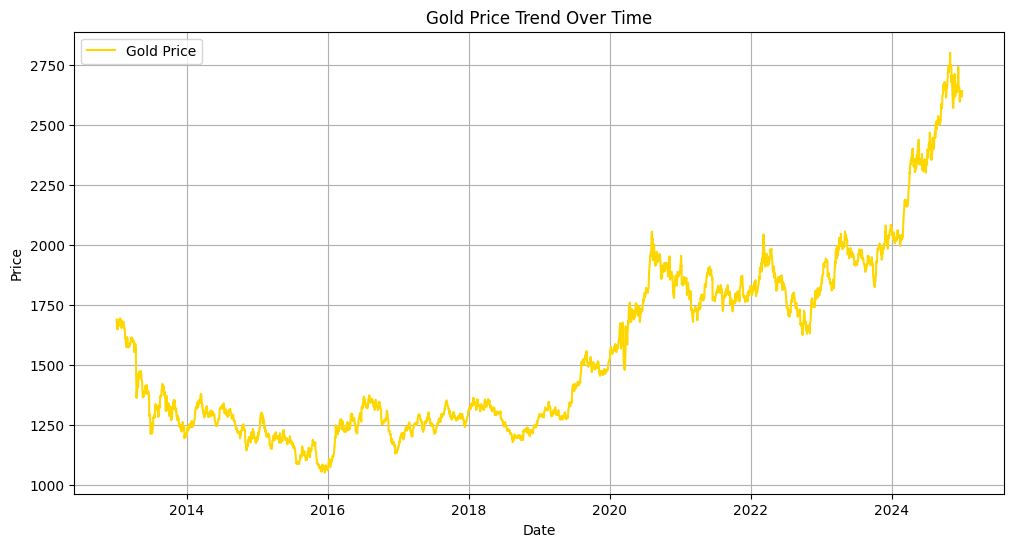

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Gold Price', color='gold')
plt.title('Gold Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

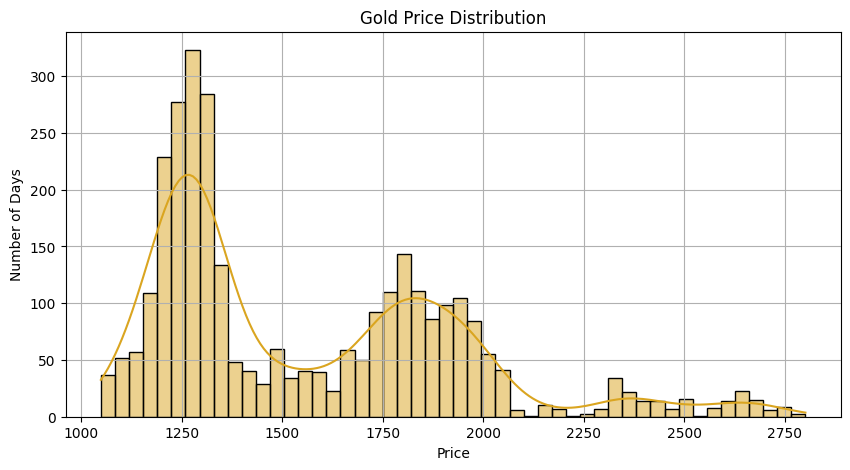

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['Price'], bins=50, color='goldenrod', kde=True)
plt.title('Gold Price Distribution')
plt.xlabel('Price')
plt.ylabel('Number of Days')
plt.grid(True)
plt.show()

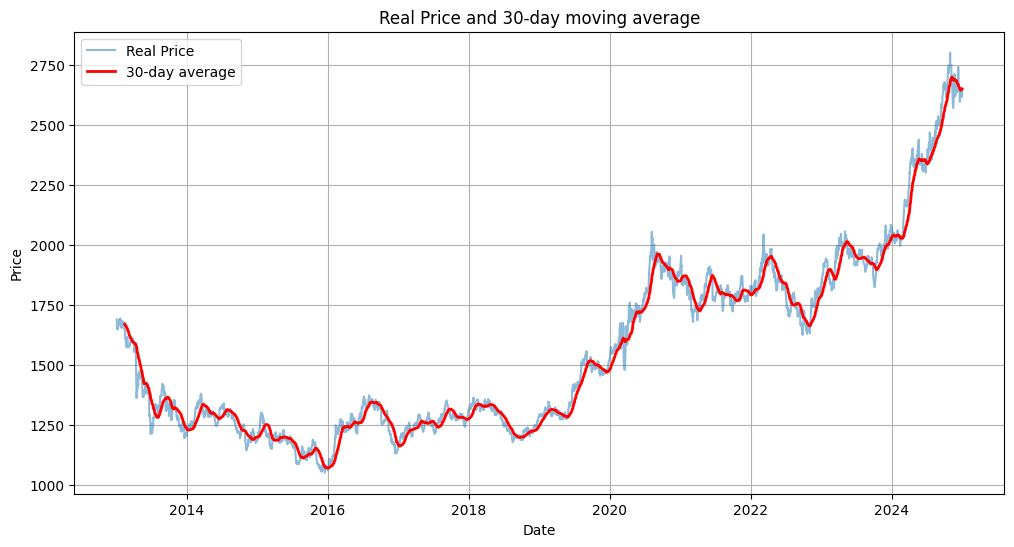

In [ ]:
rolling_mean = df['Price'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Real Price', alpha=0.5)
plt.plot(rolling_mean, label='30-day average', color='red', linewidth=2)
plt.title('Real Price and 30-day moving average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df['EMA20'] = df['Price'].ewm(span=10, adjust=True).mean()

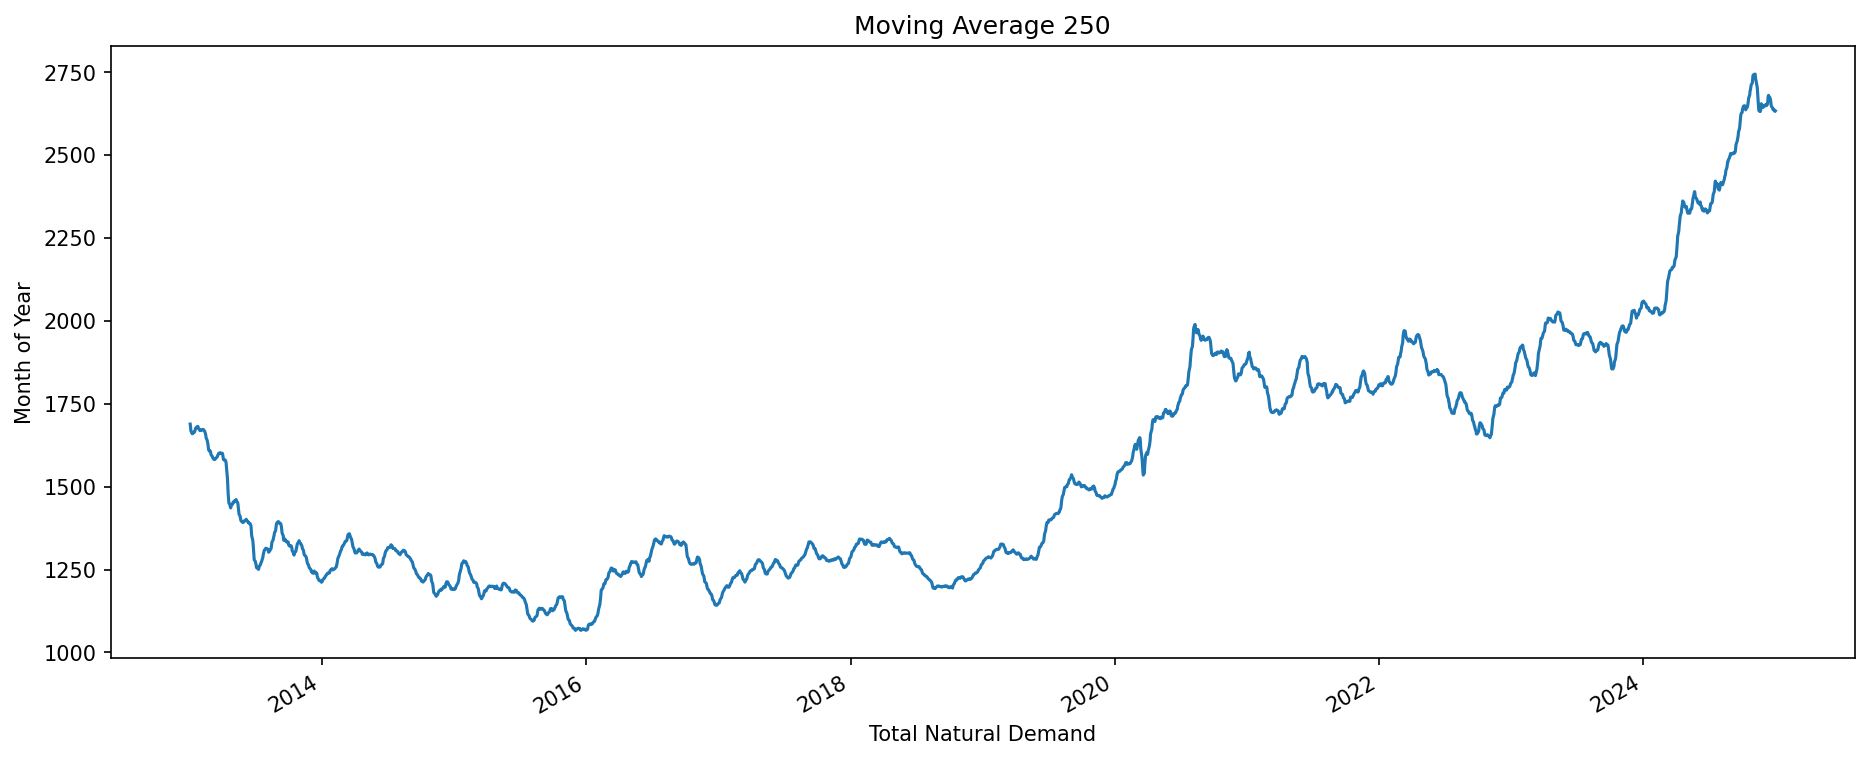

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
df.EMA20.plot()
plt.xlabel("Total Natural Demand")
plt.ylabel("Month of Year")
plt.title("Moving Average 250")
plt.show()

# Create a Model

In [ ]:
test_size = df[df.index.year == 2024].shape[0]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [ ]:
train = df.EMA20[:-test_size]
test = df.EMA20[-test_size-60:]

In [ ]:
train = scaler.transform(train.values.reshape(-1,1))
test = scaler.transform(test.values.reshape(-1,1))

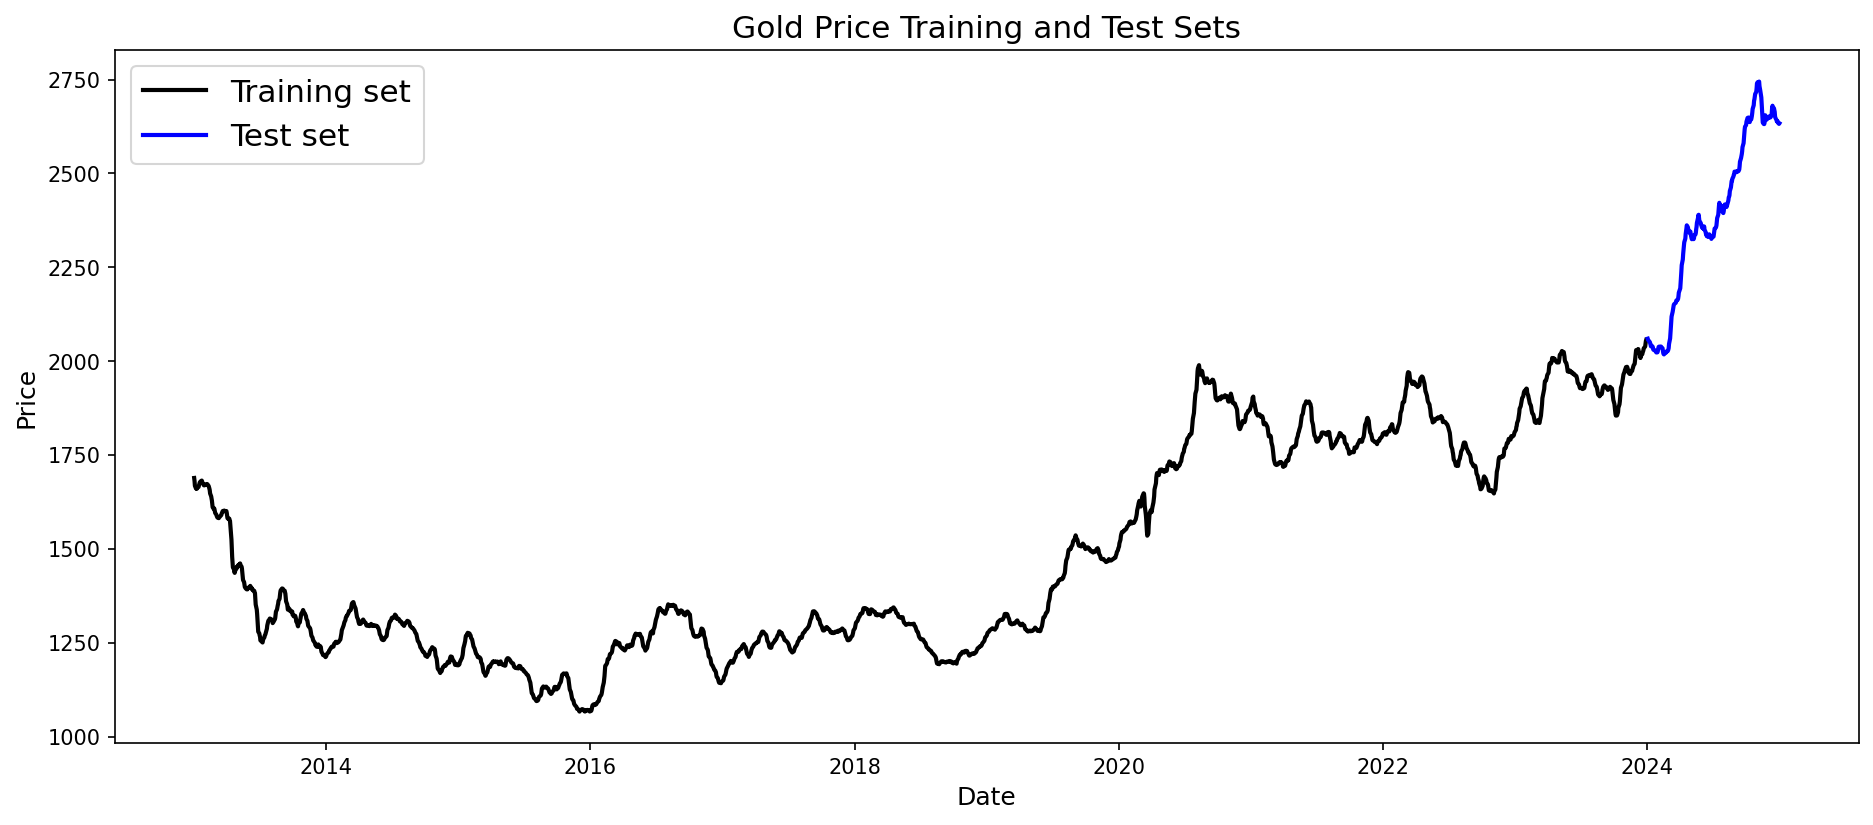

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df.index[:-test_size], df.EMA20[:-test_size], color='black', lw=2)
plt.plot(df.index[-test_size:], df.EMA20[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [ ]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length , len(data)):
        X.append(data[i-60:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [ ]:
seq_length = 60
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [ ]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2751, 60, 1)
y_train Shape:  (2751, 1)
X_test Shape:   (257, 60, 1)
y_test Shape:   (257, 1)


In [ ]:
model = Sequential()
model.add(LSTM(60, return_sequences=False, input_shape=(60, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0247
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 2.1268e-04
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.0622e-04
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.8157e-04
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 1.6660e-04
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.4873e-04
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.4501e-04
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.3234e-04
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.1616e-04
Epoch 10/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1827e-04
Epoch 11/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0199e-04
Epoch 12/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.0895e-04
Epoch 13/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.6503e-05
Epoch 14/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.7085e-05
Epoch 15/100
86/8

In [ ]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3132e-05
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [ ]:
y_test_true = y_test
y_test_pred = y_pred
y_train_pred =y_train

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
print(f'RMSE: {rmse}')

RMSE: 0.005468312455190556


In [ ]:
r2 = r2_score(y_test_true , y_test_pred)
print(f'R2-Score : {r2}')

R2-Score : 0.9981582045327403


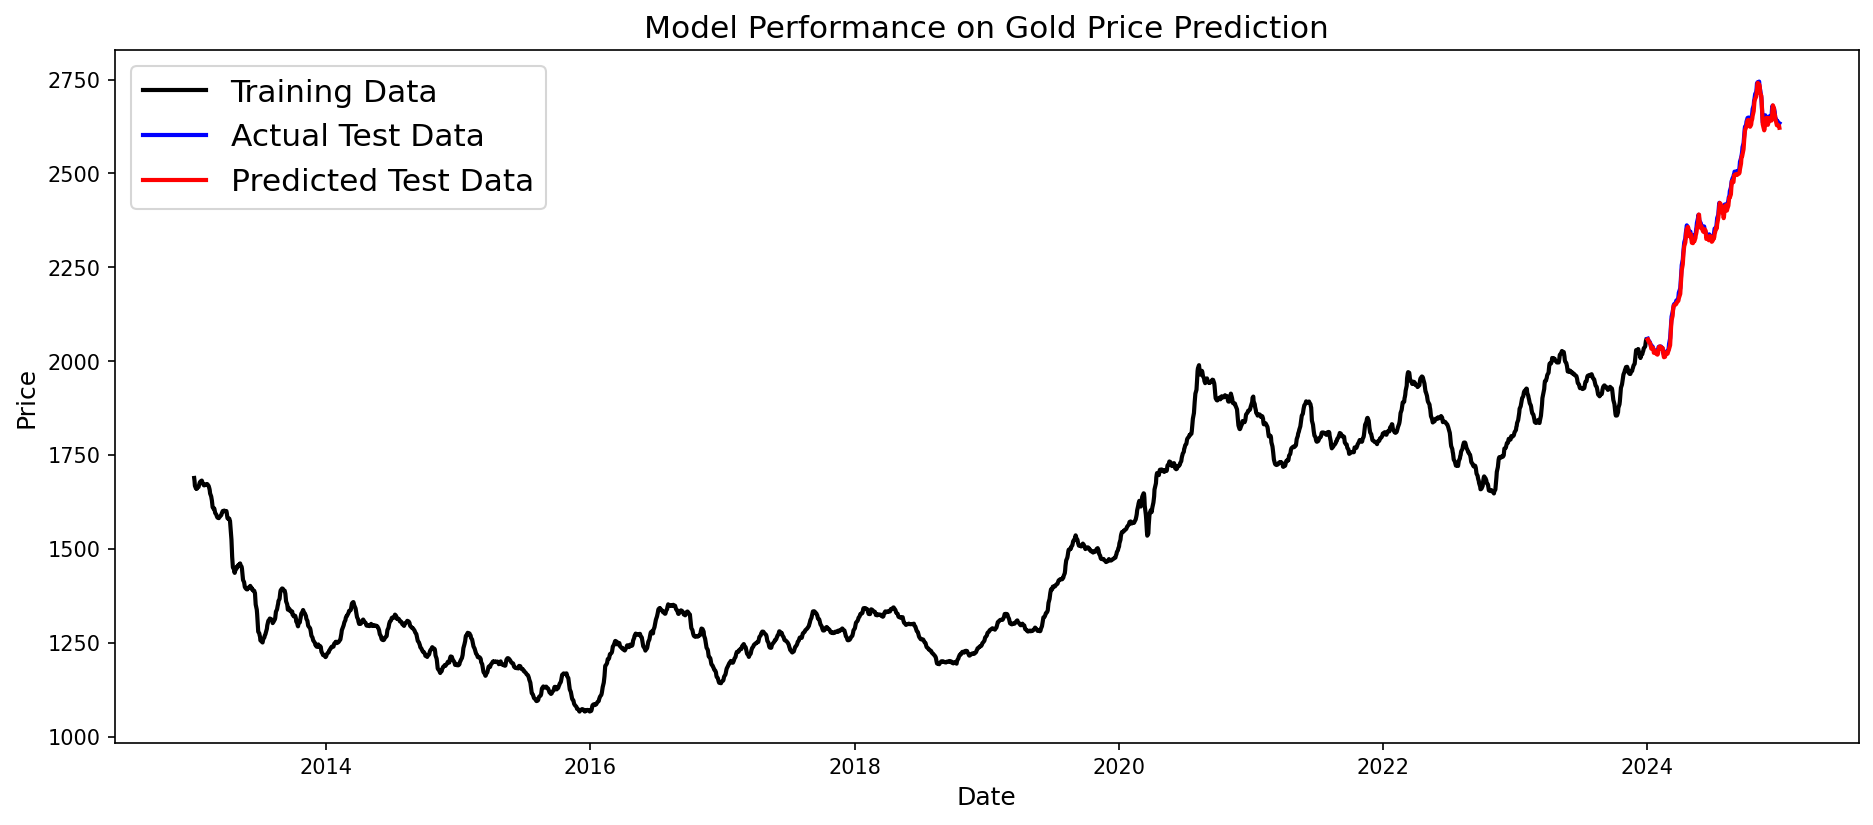

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df.index[:-test_size], scaler.inverse_transform(train), color='black', lw=2)
plt.plot(df.index[-test_size:], scaler.inverse_transform(y_test_true), color='blue', lw=2)
plt.plot(df.index[-test_size:], scaler.inverse_transform(y_test_pred), color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

# Forecast for the next 2 months

In [ ]:
future_steps = 30 * 2
lookback = 24
last_sequence = test[-lookback:].reshape(1, lookback, 1)
future_preds = []

In [ ]:
for _ in range(future_steps):
    lstm_out = model.predict(last_sequence)
    future_preds.append(lstm_out[0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[[lstm_out[0][0]]]], axis=1)


future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

In [ ]:
start_date = pd.to_datetime('2025-01-01')
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='D')

In [ ]:
forecast_df = pd.DataFrame({
    'datetime': future_dates,
    'predicted_demand': future_preds.flatten()
})
forecast_df.set_index('datetime', inplace=True)

In [ ]:
forecast_df

,predicted_demand
datetime,
2025-01-01,2617.296875
2025-01-02,2607.601562
2025-01-03,2590.006348
2025-01-04,2570.456299
2025-01-05,2550.172852
2025-01-06,2529.166992
2025-01-07,2507.349609
2025-01-08,2484.791992
2025-01-09,2461.618408


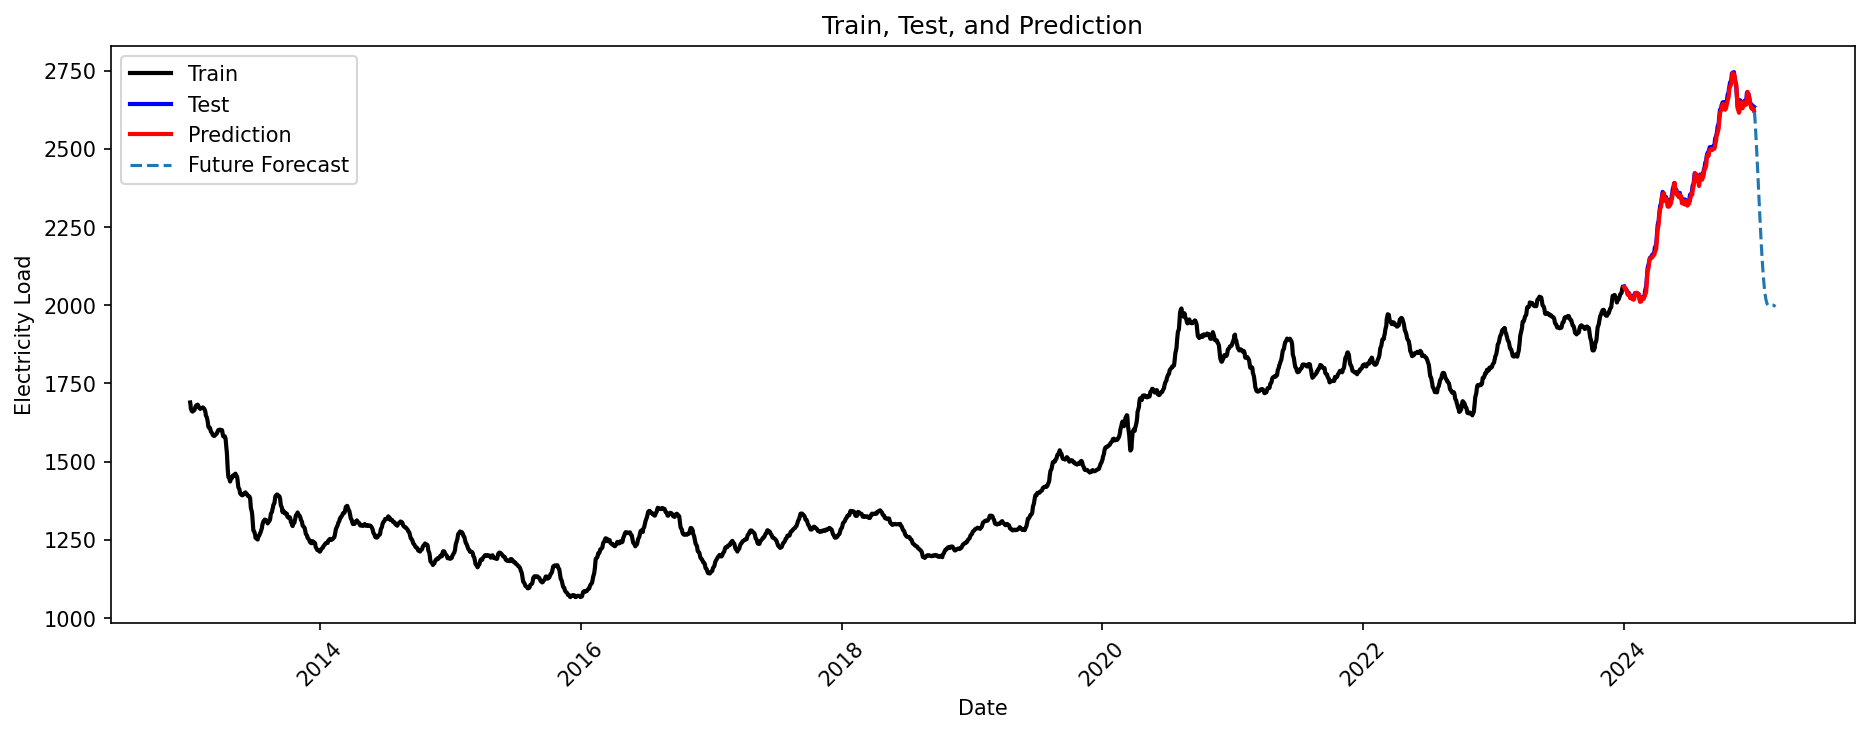

In [ ]:
plt.figure(figsize=(15, 5),dpi=150)

plt.plot(df.index[:-test_size], scaler.inverse_transform(train), color='black', lw=2,label='Train')
plt.plot(df.index[-test_size:],scaler.inverse_transform(y_test_true), color='blue', lw=2, label='Test')
plt.plot(df.index[-test_size:],scaler.inverse_transform (y_test_pred), color='red', lw=2,label='Prediction')
plt.plot(forecast_df.index, forecast_df['predicted_demand'], label='Future Forecast', linestyle='--')

plt.title('Train, Test, and Prediction')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
from tensorflow.keras.layers import GRU

# Assuming you've already done data preprocessing and scaling

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Reshape for GRU input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))


model = Sequential()
model.add(GRU(60, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train, y_train, epochs=100)

# Evaluate and predict
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R2-Score: {r2}')







Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0297
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 6.8654e-05
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.8400e-05
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 5.2283e-05
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 4.5119e-05
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 4.0551e-05
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.0313e-05
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.5643e-05
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 3.2594e-05
Epoch 10/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 3.1166e-05
Epoch 11/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 3.3999e-05
Epoch 12/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.7668e-05
Epoch 13/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 2.6858e-05
Epoch 14/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.4070e-05
Epoch 15/100
86/8

In [ ]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df.index[:-test_size], scaler(train), color='black', lw=2)
plt.plot(df.index[-test_size:], scaler(y_test_true), color='blue', lw=2)
plt.plot(df.index[-test_size:], scaler(y_test_pred), color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()


TypeError: 'MinMaxScaler' object is not callable

<Figure size 2250x900 with 0 Axes>

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.models import Sequential

# Assuming you've already done data preprocessing and scaling

# Create sequences (same as before)
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Reshape for CNN-LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

# Build the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(60))  # Match LSTM units from previous model
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100)  # Adjust epochs as needed

# Evaluate and predict
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R2-Score: {r2}')



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0159
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.9672e-04
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7091e-04
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4201e-04
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.2662e-04
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.9622e-04
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.6622e-04
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.4745e-04
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1916e-04
Epoch 10/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.1832e-04
Epoch 11/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1411e-04
Epoch 12/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.9000e-05
Epoch 13/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 8.4319e-05
Epoch 14/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 7.6026e-05
Epoch 15/100
86/8

In [ ]:
from tensorflow.keras.layers import Bidirectional

# Assuming you've already done data preprocessing and scaling

# Create sequences (same as before)
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Reshape for Bidirectional LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))

# Build the Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(60, return_sequences=False), input_shape=(seq_length, 1)))  # Wrap LSTM with Bidirectional
model.add(Dense(1))  # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100)  # Adjust epochs as needed

# Evaluate and predict
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R2-Score: {r2}')

# ... (Rest of your forecasting code can remain the same)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0237
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 6.5910e-04
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 4.6304e-04
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 3.0072e-04
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 2.2592e-04
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.8833e-04
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.3885e-04
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 1.3461e-04
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.0812e-04
Epoch 10/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.1889e-04
Epoch 11/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 9.5508e-05
Epoch 12/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 8.8407e-05
Epoch 13/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 7.4821e-05
Epoch 14/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 7.7962e-05
Epoch 15/100
86/8